In [35]:
## packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Deconvolution of bulk RNA-seq data

### 1. Data processing

#### Reading in the data

In [3]:
X = pd.read_csv('singlecell_counts.tsv', sep = '\t') # genes x cells
X.head()

,Astro,Astro_1,Astro_2,Astro_3,Astro_4,Astro_5,Astro_6,Astro_7,Astro_8,Astro_9,...,Sst_1276,Pvalb_977,Sst_1277,L5.PT_332,L5.PT_333,Sst_1278,Sncg_101,L5.PT_334,L5.PT_335,Pvalb_978
Vip,1,0,0,122,0,8,0,1,13,4,...,0,1,0,1,0,0,0,0,0,0
Sst,0,4,0,0,1,2,0,4,2,0,...,7973,1,10151,0,1,10352,1,0,2,0
Npy,0,2,0,30,0,1,0,6,1,1,...,3342,1,3440,1,1,0,0,0,3,0
Tac2,1,0,0,17,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Crh,0,0,0,2,0,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y = pd.read_csv('bulk_counts.tsv', sep = '\t') # gene x patient
y.head()

,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,...,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100
Vip,89962,208836,204719,25433,407831,669371,225500,87294,623893,270581,...,184914,97195,444923,413720,504525,352847,286476,355973,192656,609022
Sst,167504,146028,196779,54169,34428,117699,115188,46757,56044,33154,...,153439,47664,76177,157780,77403,95655,144171,238906,79249,84
Npy,186206,50600,246568,112616,170445,123460,279192,42533,142558,213507,...,54951,26042,88611,398355,153639,62190,123707,259591,253166,38241
Tac2,20463,41619,11318,8947,68359,70246,30363,6703,72599,31140,...,33814,4452,54030,43446,68586,35359,44844,64825,30121,89826
Crh,4262,22588,29041,5202,24203,39008,23064,1911,25584,18328,...,9115,13873,41875,26111,70308,84736,64274,24628,13176,42845


In [6]:
Beta = pd.read_csv('true_proportions.tsv', sep = '\t') # patient x cell type
Beta.head()

,Astro,Endo,L2.3.IT,L4,L5.IT,L5.PT,L6.CT,L6.IT,L6b,Lamp5,Macrophage,NP,Oligo,Pvalb,Sncg,Sst,Vip,VLMC
sample_1,0.073799,0.044687,0.062154,0.100873,0.012373,0.032751,0.040029,0.039592,0.089665,0.062591,0.094905,0.082678,0.016594,0.086754,0.052111,0.062445,0.007569,0.038428
sample_2,0.039765,0.083317,0.086207,0.061292,0.077237,0.035479,0.040462,0.070460,0.083516,0.023919,0.076839,0.035479,0.053418,0.009268,0.016942,0.089695,0.042157,0.074547
sample_3,0.102376,0.118796,0.085210,0.062321,0.034208,0.028486,0.001742,0.090683,0.031098,0.020027,0.002115,0.060455,0.012813,0.099764,0.044035,0.116432,0.030601,0.058838
sample_4,0.026864,0.081573,0.064223,0.065342,0.055968,0.070659,0.004477,0.015951,0.065622,0.055548,0.116692,0.106478,0.080173,0.062684,0.011753,0.030642,0.010634,0.074717
sample_5,0.087140,0.071506,0.005302,0.074225,0.050707,0.130642,0.034937,0.028276,0.117047,0.063078,0.030315,0.084829,0.027732,0.002719,0.108483,0.037249,0.022703,0.023110


#### Split the data and pseudobulk

In [ ]:
# Function for average gene expression per cell type
def pseudobulk(X):
    prefix = [i.split('_')[0] for i in X.columns] 
    initialize = True
    for pre in np.unique(prefix):
        idx_prefix = [i == pre for i in prefix]
        celltype_mean = X.iloc[:,idx_prefix].mean(axis = 1)
        if initialize:
            X_mean = pd.DataFrame(celltype_mean, columns = [pre])
            initialize = False
        else:
            X_mean[pre] = celltype_mean
    return(X_mean)

In [7]:
from sklearn.model_selection import train_test_split
# Because of the generation process of the data, there will be data leakage with this splitting. 
# To be completely correct, the patient data needs to be known of X (which data used for y generation) 
# to be taken into account in the splitting strategy. But I guess this is fine for now...
# Note: Beta also needs to be splitted!
prefix = [i.split('_')[0] for i in X.columns]
X_train, X_val = train_test_split(X.T, stratify = prefix , test_size=0.25, random_state=42)
y_train, y_val, Beta_train, Beta_val = train_test_split(y.T, Beta,  test_size=0.25, random_state=42)


### 2. Training and testing the models

In [150]:
# Plot predictions
def plot_one_sample(true_props, predicted_props):
    plt.axline([0,0], slope=1, linestyle='--', color='lightgrey')
    plt.scatter(true_props, predicted_props)
    plt.xlabel('True proportions')
    plt.ylabel('Predicted proportions')
    plt.show()

#### Non-negative least squares

Non-negative least squares
RMSE: 0.02591967459813415
Pearson correlation: 0.7543905955873682


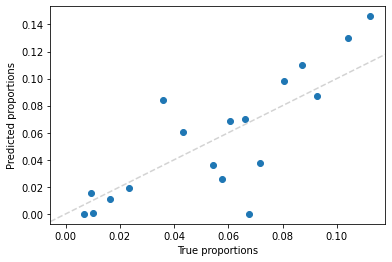

In [152]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
# Perform the pseudobulk
X_mean = pseudobulk(X)

#Fit the model, no hyperparameter optimization so no splitting
clf = LinearRegression(positive=True)
clf.fit(X_mean, y)

# Need to 'normalize' predictions so they sum up to 1
pred_nnls = clf.coef_.T/np.sum(clf.coef_, axis=1)

print('Non-negative least squares')
print('RMSE:',  sqrt(mean_squared_error(Beta,pred_nnls.T)))
# Average correlation across all patients
print('Pearson correlation:', np.mean([pearsonr(Beta.iloc[i], pred_nnls.T[i])[0] for i in range(100)]))

# Plot predictions
plot_one_sample(Beta.iloc[10], pred_nnls.T[10])

#### Bayesian Ridge

Bayesian ridge
RMSE: 0.02685116687778853
Pearson correlation: 0.7464994040631849


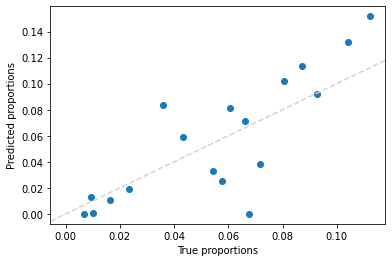

In [153]:
from sklearn import linear_model
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.multioutput import MultiOutputRegressor
# Note: it is a multi-output regressor which complicates things a little bit

# Fit the model, no hyperparameter optimization so no splitting
reg = linear_model.BayesianRidge()
multiclf = MultiOutputRegressor(reg) 
multiclf.fit(X_mean, y)

# MultiOutputRegression makes one model per target, so the formatting is a bit different
df = pd.DataFrame(multiclf.estimators_[0].coef_).T
for i in range(1, len(multiclf.estimators_)):
    df = pd.concat([df, pd.DataFrame(multiclf.estimators_[i].coef_).T], axis = 0)

# 'Normalize' predictions so they sum up to 1, set negative values to zero
pred_br = df.T/np.sum(df.T)
pred_br[pred_br < 0] = 0

print('Bayesian ridge')
print('RMSE:',  sqrt(mean_squared_error(Beta, pred_br.T)))
# Average correlation across all patients
print('Pearson correlation:', np.mean([pearsonr(Beta.iloc[i], pred_br.T.iloc[i])[0] for i in range(100)]))

# Plot predictions
plot_one_sample(Beta.iloc[10], pred_br.T.iloc[10])

#### Decision tree

Best score train: 0.01562262784628779
Decision tree
RMSE: 0.12910399423636465
Pearson correlation: 0.0757055918593597


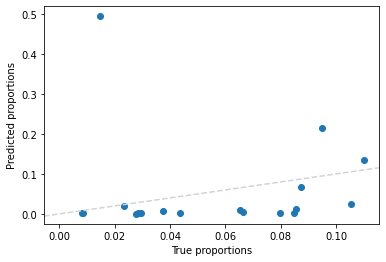

In [156]:
from sklearn import tree
from sklearn.model_selection import ParameterGrid
import warnings
warnings.simplefilter(action='error', category=FutureWarning)
# Note: with the difficulty of splitting GridSearchCV and or RandomSearchCV becomes difficult
# And which dimensions to input is kind of tricky

# pseudobulk the data
X_train_mean = pseudobulk(X_train.T)
X_val_mean = pseudobulk(X_val.T)

# perform hyperoptimization on the training dataset
parameters = dict(
    max_depth = [30,None])
clf = tree.DecisionTreeRegressor()
param_grid = ParameterGrid(parameters)

metrics = []
classifiers = []
metrics = np.zeros(len(list(param_grid)))

j = 0
for params in param_grid:
    clf = clf.set_params(**params)
    multiclf = MultiOutputRegressor(clf)
    
    multiclf.fit(X_train_mean, y_train.T)
    
    df = pd.DataFrame(multiclf.estimators_[0].feature_importances_).T
    for i in range(1, len(multiclf.estimators_)):
        df = pd.concat([df, pd.DataFrame(multiclf.estimators_[i].feature_importances_).T], axis=0)
        
    metrics[j] = (mean_squared_error(Beta_train,df))
    j += 1
    
metrics = list(metrics)
best_score_train = min(metrics)
print('Best score train:', best_score_train)

index_best_params= metrics.index(best_score_train)
Best_param = list(param_grid)[index_best_params]

# Evaluate the best model
clf.set_params(**Best_param)
multiclf = MultiOutputRegressor(clf)
multiclf.fit(X_val_mean, y_val.T)

df = pd.DataFrame(multiclf.estimators_[0].feature_importances_).T
for i in range(1, len(multiclf.estimators_)):
    df = pd.concat([df,pd.DataFrame(multiclf.estimators_[i].feature_importances_).T], axis=0)

# 'Normalize' predictions so they sum up to 1, set negative values to zero
pred_tree = df.T/np.sum(df.T)
pred_tree[pred_tree < 0] = 0

print('Decision tree')
print('RMSE:', sqrt(mean_squared_error(Beta_val,pred_tree.T)))
print('Pearson correlation:', np.mean([pearsonr(Beta_val.iloc[i], pred_tree.T.iloc[i])[0] for i in range(25)]))

# Plot predictions
plot_one_sample(Beta_val.iloc[10], pred_tree.T.iloc[10])

#### SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import ParameterGrid
# Note, I stopped this after 8 min without any output printed. This takes quite a while

parameters = dict(
    C= [1, 10], 
    kernel= ['linear'])
clf = SVR()
param_grid = ParameterGrid(parameters)

metrics = []
classifiers = []
metrics = np.zeros(len(list(param_grid)))
j = 0
for params in param_grid:
    clf = clf.set_params(**params)
    multiclf = MultiOutputRegressor(clf)
    multiclf.fit(X_train_mean, y_train.T)
    
    df = pd.DataFrame(multiclf.estimators_[0].coef_).T
    for i in range(1, len(multiclf.estimators_)):
        df = df.append(pd.DataFrame(multiclf.estimators_[i].coef_).T)
        
    metrics[j] = (mean_squared_error(Beta,df ))
    j += 1
    
best_score_train = min(metrics)
print('Best score train', best_score_train)
index_best_params= metrics.index(best_score_train)

clf.set_params(list(param_grid)[index_best_params])
multiclf = MultiOutputRegressor(clf)
multiclf.fit(X_val_mean, y_val)

df = pd.DataFrame(multiclf.estimators_[0].coef_).T
for i in range(1, len(multiclf.estimators_)):
    df = df.append(pd.DataFrame(multiclf.estimators_[i].coef_).T)
    
# 'Normalize' predictions so they sum up to 1, set negative values to zero
pred_svr = df.T/np.sum(df.T)
pred_svr[pred_svr < 0] = 0

print('SVR')
print('RMSE:', sqrt(mean_squared_error(Beta_val,pred_svr.T)))
print('Pearson correlation:', np.mean([pearsonr(Beta_val.iloc[i], pred_svr.T.iloc[i])[0] for i in range(25)]))

# Plot predictions
plot_one_sample(Beta_val.iloc[10], pred_svr.T.iloc[10])